In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils import roc_results, gdf_pca, stocks_numbers
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 24000
stocks = stocks_numbers.chosen_stocks
should_save_fig = False

In [10]:
df_scores = pd.read_csv('../gdf_pca/res_fake_balanced_que.csv')
df_scores = df_scores[df_scores['stock'].isin(stocks)]

,test_matthews,matthews,test_roc_auc,roc_auc
count,15.000000,15.000000,15.000000,15.000000
mean,0.141092,0.143649,0.570378,0.571737
std,0.053984,0.040837,0.026982,0.020360
min,0.063458,0.082229,0.531571,0.541029
25%,0.097216,0.111420,0.548519,0.555716
50%,0.134481,0.135102,0.567189,0.567660
75%,0.192096,0.175608,0.595786,0.587774
max,0.218069,0.209878,0.609202,0.604737


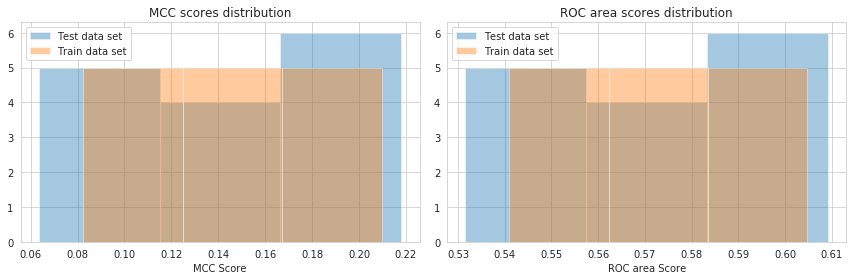

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(df_scores['test_matthews'], kde=False, label='Test data set', ax=ax1)
sns.distplot(df_scores['matthews'], kde=False, label='Train data set', ax=ax1)

ax1.legend()
ax1.set_xlabel('MCC Score')
ax1.set_title('MCC scores distribution')

sns.distplot(df_scores['test_roc_auc'], kde=False, label='Test data set', ax=ax2)
sns.distplot(df_scores['roc_auc'], kde=False, label='Train data set', ax=ax2)

ax2.legend()
ax2.set_xlabel('ROC area Score')
ax2.set_title('ROC area scores distribution')
plt.tight_layout()
#plt.savefig('results_log_que_score_dist.png')

df_scores[['test_matthews', 'matthews', 'test_roc_auc', 'roc_auc']].describe()

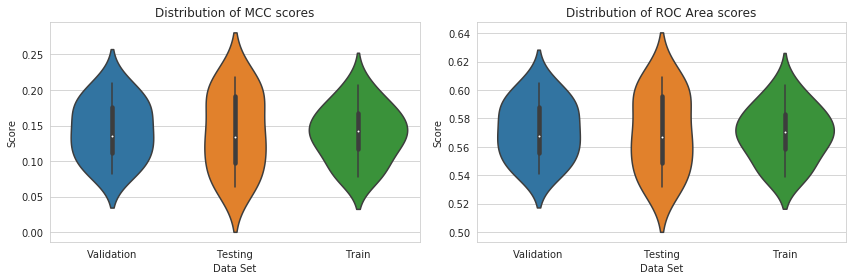

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'matthews', 'roc_auc', 
           'test_matthews', 'test_roc_auc', 'train_matthews', 'train_roc_auc']

df = df_scores[columns].copy()
df.rename(columns={'matthews': 'Validation', 'test_matthews': 'Testing', 'train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'roc_auc', 'test_roc_auc', 'train_roc_auc'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_scores[columns].copy()
df.rename(columns={'roc_auc': 'Validation', 'test_roc_auc': 'Testing', 'train_roc_auc': 'Train'}, inplace=True)
df = df.melt(['stock', 'matthews', 'test_matthews', 'train_matthews'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
plt.savefig('violin_distribution_scores_log_que.png')

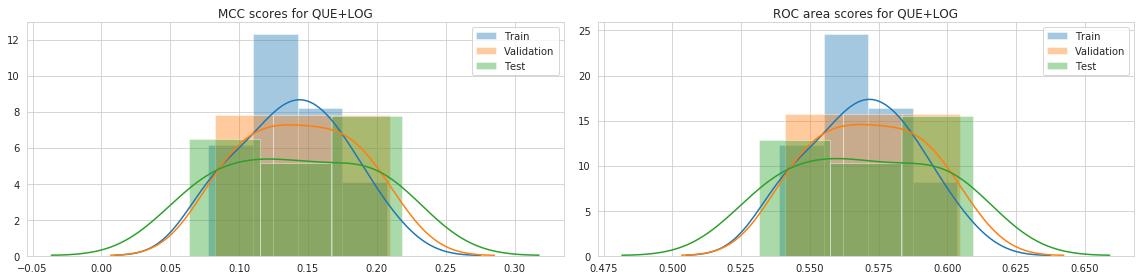

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

sns.distplot(df_scores[['train_matthews']], label='Train', ax=ax1)
sns.distplot(df_scores[['matthews']], label='Validation', ax=ax1)
sns.distplot(df_scores[['test_matthews']], label='Test', ax=ax1)
ax1.legend()
ax1.set_title('MCC scores for QUE+LOG')

sns.distplot(df_scores[['train_roc_auc']], label='Train', ax=ax2)
sns.distplot(df_scores[['roc_auc']], label='Validation', ax=ax2)
sns.distplot(df_scores[['test_roc_auc']], label='Test', ax=ax2)
ax2.legend()
ax2.set_title('ROC area scores for QUE+LOG')
plt.tight_layout()
if should_save_fig:
    plt.savefig('results_que_log.png')

In [14]:
print(df_scores[['train_matthews', 'matthews', 'test_matthews', 
        'train_roc_auc', 'roc_auc', 'test_roc_auc']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  train\_matthews &   matthews &  test\_matthews &  train\_roc\_auc &    roc\_auc &  test\_roc\_auc \\
\midrule
count &       15.000000 &  15.000000 &      15.000000 &      15.000000 &  15.000000 &     15.000000 \\
mean  &        0.138725 &   0.143649 &       0.141092 &       0.569307 &   0.571737 &      0.570378 \\
std   &        0.038537 &   0.040837 &       0.053984 &       0.019251 &   0.020360 &      0.026982 \\
min   &        0.077707 &   0.082229 &       0.063458 &       0.538848 &   0.541029 &      0.531571 \\
25\%   &        0.117391 &   0.111420 &       0.097216 &       0.558655 &   0.555716 &      0.548519 \\
50\%   &        0.141870 &   0.135102 &       0.134481 &       0.570731 &   0.567660 &      0.567189 \\
75\%   &        0.166938 &   0.175608 &       0.192096 &       0.583332 &   0.587774 &      0.595786 \\
max   &        0.207445 &   0.209878 &       0.218069 &       0.603720 &   0.604737 &      0.609202 \\
\bottomrule
\end{tabula

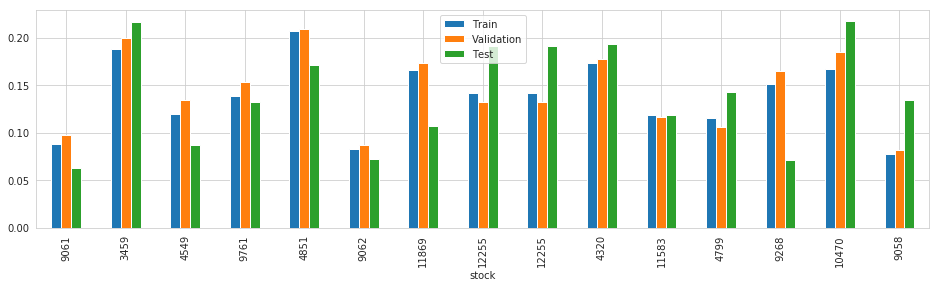

In [15]:
df_scores.index = df_scores['stock']
df_scores[['train_matthews', 'matthews', 'test_matthews']].plot(kind='bar', figsize=(16, 4))
plt.legend(['Train', 'Validation', 'Test'])

In [17]:
df_scores

,Unnamed: 0,f1,kappa,kernel,matthews,precision,recall,roc_auc,stock,test_f1,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
stock,,,,,,,,,,,,,,,,,,,,,
9061,9061,0.554615,0.097959,fake,0.098128,0.540014,0.570157,0.549012,9061,0.537271,...,0.088261,0.539007,0.553532,0.544125,0.548416,0.074964,0.075163,0.533282,0.564909,0.537495
3459,3459,0.607580,0.199066,fake,0.199841,0.593377,0.623980,0.599781,3459,0.628845,...,0.188362,0.587904,0.608221,0.594150,0.589228,0.186035,0.186098,0.582900,0.595758,0.593060
4549,4549,0.559535,0.133565,fake,0.135102,0.524277,0.600979,0.567660,4549,0.549326,...,0.120430,0.535065,0.549962,0.560279,0.531993,0.124260,0.124560,0.534951,0.530517,0.562218
9761,9761,0.578442,0.153072,fake,0.153285,0.582641,0.575081,0.576513,9761,0.549664,...,0.138852,0.572902,0.593305,0.569346,0.590350,0.138888,0.139208,0.572577,0.609415,0.569379
4851,4851,0.596299,0.209318,fake,0.209878,0.612999,0.581184,0.604737,4851,0.572065,...,0.207445,0.608402,0.609486,0.603720,0.612227,0.210918,0.211121,0.607105,0.617920,0.605434
9062,9062,0.553383,0.087124,fake,0.087186,0.545121,0.562154,0.543582,9062,0.538682,...,0.082899,0.548249,0.545907,0.541452,0.550490,0.087341,0.087379,0.550941,0.550285,0.543684
11869,11869,0.586003,0.173597,fake,0.173774,0.596897,0.575737,0.586892,11869,0.527120,...,0.166246,0.593905,0.555793,0.583015,0.571248,0.179295,0.180080,0.599577,0.545760,0.589686
12255,12255,0.558920,0.131887,fake,0.132380,0.566221,0.554251,0.566048,12255,0.583888,...,0.141870,0.566107,0.608586,0.570731,0.597737,0.155202,0.156661,0.566744,0.633548,0.577645
12255,12255,0.558920,0.131887,fake,0.132380,0.566221,0.554251,0.566048,12255,0.583888,...,0.141870,0.566107,0.608586,0.570731,0.597737,0.155202,0.156661,0.566744,0.633548,0.577645
